# Advanced example

This guide shows how to analyze real images jointly. It is recommended to start off with the [Quickstart Tutorial](quickstart.ipynb) before engaging in this example. The dataset consists of a MALDI and optical images of mouse urinary bladder. These are processed images from original images downloaded from PRIDE (dataset id [PXD001283](https://www.ebi.ac.uk/pride/archive/projects/PXD001283)).

The images are located in the ``data/Mouse_Urinary_Bladder_PXD001283/`` directory: ms_image_resized.imzML, optical_image.tiff.

We aim at finding the spatial correlations between the ion images in MALDI and the optical image.


## Data processing

The following section explains how the images were processed from the original images available from PRIDE. It is **not necessary to replicate these steps**, but they are detailed for reproducibility purposes. Jump straight to [Fusion workflow](#Fusion-workflow) if you wish to get started with this example.

The original MALDI image from PRIDE has different *m-z* values. First, all spectra are aligned on the same *m/z*-axis following the procedure described in the [Data](data.rst) section (parameters: *factor*=150, *level*=2, *nbpeaks*=1, *step*=0.02). Then, the images are resized using the ``examples/resize_imzml.py`` script with a 0.5 scale factor.

Peak selection and alignment are already done, thus there is **no need for further spectra processing**.

In essence, the following scripts were applied. First, we download the data from PRIDE:

```bash
cd data/Mouse_Urinary_Bladder_PXD001283/
python download.py
```

After completion (might take a while), the three following downloaded files should be located in the ``data/Mouse_Urinary_Bladder_PXD001283``: ms_image.imzML, ms_image.imzML, and optical_image.tiff.

Next, we align and resize the image:

```bash
cd ../../
python -m examples.same_mz_axis -i data/Mouse_Urinary_Bladder_PXD001283/ms_image.imzML -o data/Mouse_Urinary_Bladder_PXD001283/ms_image_aligned.imzML -f 150 -l 2 -n 1 -s 0.02
python -m examples.resize_imzml -i data/Mouse_Urinary_Bladder_PXD001283/ms_image_aligned.imzML -o data/Mouse_Urinary_Bladder_PXD001283/ms_image_resized.imzML -f 0.5
```

The optical image is transformed by a 5° counter-clockwise rotation followed by a +100 px translation on the *x*-axis and a scaling by a factor of 0.9.


## Fusion workflow

Let's import the necessary modules and define some utility functions:

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import string
import SimpleITK as sitk

rootpath = "../../"
imagepath = "data/Mouse_Urinary_Bladder_PXD001283/"
sys.path.append(os.path.join(os.path.dirname(os.path.abspath("__file__")), rootpath))

def display_image(image):
    plt.axis("off")
    plt.imshow(image, cmap="gray")
    plt.show()

def display_images(*images):
    fig, ax = plt.subplots(1, len(images))
    for i in range(len(images)):
        ax[i].axis('off')
        ax[i].imshow(images[i], cmap="gray")
        ax[i].text(0.4, -0.2, "(" + string.ascii_lowercase[i] + ")", transform=ax[i].transAxes, size=18)
    plt.show()

### Input, Visualization

The data is available in the `data/Mouse_Urinary_Bladder_PXD001283` directory.
First, read the data and display the spectrum of a pixel:

(8711, 2, 214)


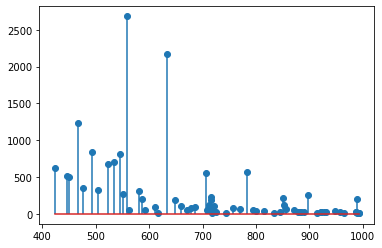

In [3]:
import esmraldi.imzmlio as io

imzml = io.open_imzml(rootpath + imagepath + "ms_image_resized.imzML")
spectra = io.get_spectra(imzml)

print(spectra.shape)
mz_first, intensities_first = spectra[1, 0], spectra[1, 1]
indices = intensities_first > 1
plt.stem(mz_first[indices], intensities_first[indices], use_line_collection=True)
plt.show()

The variable `spectra` is a 3D numpy array, with 8711 pixels (67x130) and where each pixel is associated to a spectrum with 214 peaks. The peaks are already selected and aligned for this dataset.

Then, we display the image of the ion of *m/z* 741.7 +/- 0.25:

(67, 130)


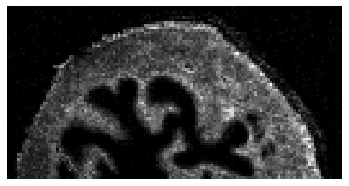

In [4]:
image = io.get_image(imzml, 741.7, 0.25)
display_image(image)

Now, we read the optical image:

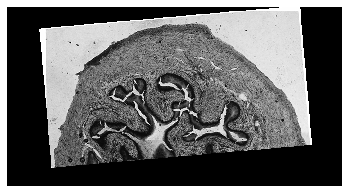

In [6]:
from skimage import io as skio

optical_image = skio.imread(rootpath + imagepath + "optical_image.png", as_gray=True)
display_image(optical_image)

### Segmentation

Next, a representative image is extracted from the set of MALDI ion images. This is achieved by **region growing on a subset of relevant images**, i.e. non-noisy images.

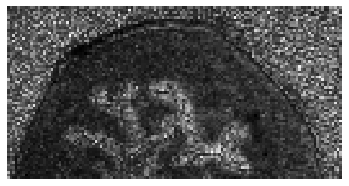

In [7]:
import esmraldi.segmentation as seg

maldi_image = io.to_image_array(imzml)
maldi_image = np.transpose(maldi_image, (1, 0, 2))
maldi_image = io.normalize(maldi_image)

# Relevant images
spatially_coherent = seg.find_similar_images_area(maldi_image, 300, quantiles=[60, 70, 80, 90])

# Mean image
mean_image = np.average(spatially_coherent, axis=-1)

# Region growing
seeds = set(((1, 1), (0, 0)))
list_end, _ = seg.region_growing(spatially_coherent, seedList=seeds, lower_threshold=30)
x = [elem[0] for elem in list_end]
y = [elem[1] for elem in list_end]
mask = np.ones_like(mean_image)
mask[x, y] = 0
segmented_image = np.ma.array(mean_image, mask=mask)
segmented_image = segmented_image.filled(0)

display_image(segmented_image)

### Registration

At this stage, both shapes in the optical and MALDI  images can be matched. In our case, we register **the MALDI segmented image onto the optical image**.

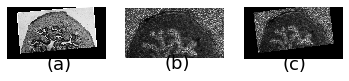

In [8]:
import esmraldi.registration as reg

segmented_itk = sitk.Cast(sitk.GetImageFromArray(segmented_image), sitk.sitkFloat32)
optical_itk = sitk.Cast(sitk.GetImageFromArray(optical_image), sitk.sitkFloat32)
segmented_itk = seg.resize(segmented_itk, optical_itk.GetSize())
segmented_itk = sitk.Cast(segmented_itk, sitk.sitkFloat32)

number_bins = 8
sampling_percentage = 0.1
registration = reg.register(optical_itk, segmented_itk, number_bins, sampling_percentage, seed=0, learning_rate=0.8, relaxation_factor=0.8, min_step=0.0001)
registered_seg_itk = registration.Execute(segmented_itk)
registered_seg_image = sitk.GetArrayFromImage(registered_seg_itk)

display_images(optical_image, segmented_image, registered_seg_image)

(a&#8291;) Optical fixed image, (b) original MALDI segmented image and (c) registered MALDI image.

Finally, we apply the registration to the original MALDI image:

In [12]:
registered_itk = sitk.GetImageFromArray(maldi_image)
registered_itk = seg.resize(registered_itk, optical_itk.GetSize())
registered_itk = sitk.Cast(registered_itk, sitk.sitkFloat32)
size = registered_itk.GetSize()

size = [size[1], size[2], size[0]]
out_register = sitk.Image(size, registered_itk.GetPixelID() )

for i in range(registered_itk.GetSize()[0]):
    slice = registered_itk[i, :, :]
    slice.SetSpacing(optical_itk.GetSpacing())
    slice_registered = registration.Execute(slice)
    slice_registered = sitk.JoinSeries(slice_registered)
    out_register = sitk.Paste(out_register, slice_registered, slice_registered.GetSize(), destinationIndex=[0, 0, i])

registered_image = np.transpose(sitk.GetArrayFromImage(out_register), (1, 2, 0))

(1042, 558, 214)


### Joint statistical analysis

The final step of the workflow is to find the MALDI ion images whose distribution correlate with the optical image.

We use non-negative matrix factorization (NMF) to find spatial correlations.

We search for the 3 ion images which are closest to the optical image:

Closest m/z ratio  [422.92754752 581.11260264 610.64008476]


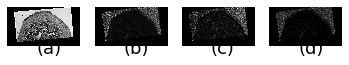

In [13]:
import esmraldi.fusion as fusion

optical_flatten = fusion.flatten(optical_image)
maldi_flatten = fusion.flatten(registered_image)

# Reduction by NMF
mzs = spectra[0, 0, :]
fit_red = fusion.nmf(maldi_flatten, n=7)
reduction = fit_red.transform(maldi_flatten)
point_optical = fit_red.transform(optical_flatten)
weights = [1 for i in range(reduction.shape[1])]

similar_images, similar_mzs, distances = fusion.select_images(registered_image, point_optical, reduction, weights, mzs, labels=None, top=None)

print("Closest m/z ratio ", similar_mzs[:3])
display_images(optical_image, similar_images[..., 0], similar_images[..., 1], similar_images[..., 2])